In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from collections import namedtuple
from datetime import date, timedelta

from algo.sde.ornstein_uhlenbeck_optimisation import OptimiserOU
from algo.sde.ornstein_uhlenbeck_parameters import HedgeParamsOU, ModelParamsOU
from etl.yfinance_data import get_pairs_data


sns.set_style("darkgrid")

In [2]:
## Get all data

# 730 days is the max, includes today.
num_data_full = 24*729

# Size of initial training set. Note: 23 trading days per month.
num_train_initial = 24*23*12
# num_train_initial = 24*23*6

# Size of each test period. Note: 1 futures trading week = 6 days. TODO: start on Sunday?
num_test_window = 24*6


# Instruments and dates
ticker1 = "BZ=F"
ticker2 = "CL=F"
end_date = date.today()
start_date = end_date - timedelta(hours=num_data_full)
df_full = get_pairs_data(ticker1, ticker2, start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"), interval="1h")


print(f"\nDates Requested: {start_date} to {end_date}")
print(f"Dates Received: {df_full.index[0]} to {df_full.index[-1]}\n")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Dates Requested: 2020-11-25 to 2022-11-24
Dates Received: 2020-11-24 19:00:00-05:00 to 2022-11-23 18:00:00-05:00



In [3]:
## Fit model on initial training data

# Model Input Parameters
dt = 1   # Let one unit of time be equivalent to one step in the data.
A = 1.0  # For every $A long/short in asset1, we go $B short/long in asset2.


# TODO: back-calculate (data_size_full-train_size_initial) % test_size_window
start_train_index = 0
end_train_index = start_train_index + num_train_initial

df_train = df_full.iloc[start_train_index : end_train_index]

optimiser_train = OptimiserOU(A=A, dt=dt)
hp_train, _ = optimiser_train.optimise(asset1=df_train["S1"].to_numpy(), asset2=df_train["S2"].to_numpy())

alpha = hp_train.alpha
beta = hp_train.beta

In [4]:
## Test window, e.g. 1 week.
start_test_index = start_train_index + num_train_initial
end_test_index = start_test_index+num_test_window
df_test = df_full.iloc[start_test_index : end_test_index]

In [5]:
## Evaluate performance
# 1. Assess entry/exit
# 2. Do trades: assume market price.

# TODO: add cointegration pre-trade checks.

# Compute spreads using (alpha, beta) calibrated in training.
df_train["spread"] = alpha*df_train["S1"] - beta*df_train["S2"]
df_test["spread"] = alpha*df_test["S1"] - beta*df_test["S2"]

# Equiv. df_full.iloc[start_train_index : end_test_index]
df_train_test = pd.concat([df_train, df_test])

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_1303/897660045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["spread"] = alpha*df_train["S1"] - beta*df_train["S2"]
/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_1303/897660045.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["spread"] = alpha*df_test["S1"] - beta*df_test["S2"]


In [ ]:
# TODO: move plots to MR notebook?

Text(0.5, 1.0, 'Flat Metrics on Spread, X')

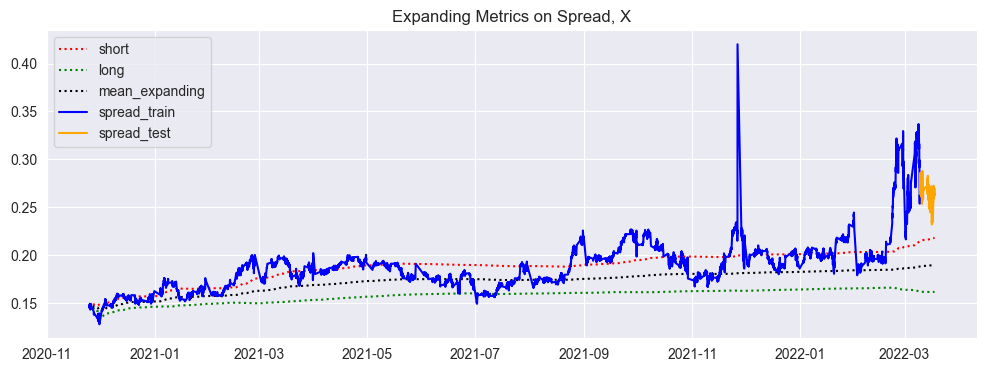

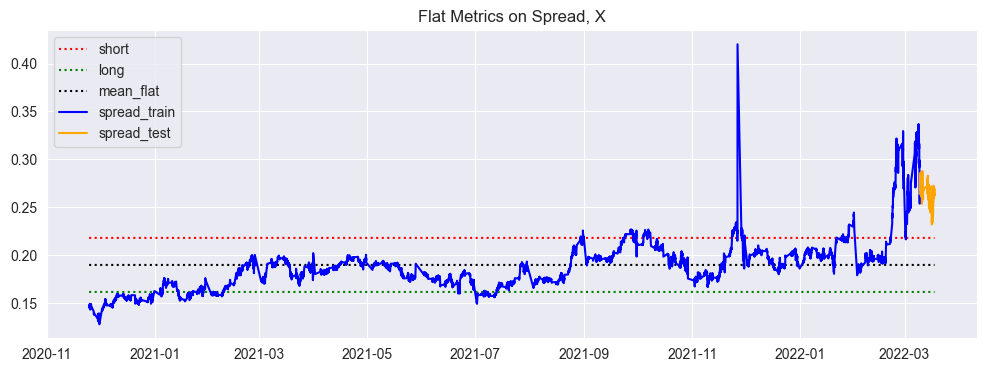

In [35]:
# Entry/Exit Signals - SD from mean


# Plot expanding - PREFERRED
plt.figure(figsize=(12, 4))

num_sd = 1.0

# Plot expanding
df_train_test["UB_expanding"] = df_train_test["spread"].expanding().mean() + num_sd * df_train_test["spread"].expanding().std()
df_train_test["LB_expanding"] = df_train_test["spread"].expanding().mean() - num_sd * df_train_test["spread"].expanding().std()
df_train_test["mean_expanding"] = df_train_test["spread"].expanding().mean()
plt.plot(df_train_test.index, df_train_test["UB_expanding"], linestyle="dotted", color="red", label="short")
plt.plot(df_train_test.index, df_train_test["LB_expanding"], linestyle="dotted", color="green", label="long")
plt.plot(df_train_test.index, df_train_test["mean_expanding"], linestyle="dotted", color="blue", label="mean_expanding")

plt.plot(df_train.index, df_train["spread"], color="blue", label="spread_train")
plt.plot(df_test.index, df_test["spread"], color="orange", label="spread_test")
plt.legend()
plt.title("Expanding Metrics on Spread, X")


# Plot flat WITH look-ahead
plt.figure(figsize=(12, 4))
df_train_test["UB_flat"] = df_train_test["spread"].mean() + num_sd * df_train_test["spread"].std()
df_train_test["LB_flat"] = df_train_test["spread"].mean() - num_sd * df_train_test["spread"].std()
df_train_test["mean_flat"] = df_train_test["spread"].mean()
plt.plot(df_train_test.index, df_train_test["UB_flat"], linestyle="dotted", color="red", label="short")
plt.plot(df_train_test.index, df_train_test["LB_flat"], linestyle="dotted", color="green", label="long")
plt.plot(df_train_test.index, df_train_test["mean_flat"], linestyle="dotted", color="blue", label="mean_flat")

plt.plot(df_train.index, df_train["spread"], color="blue", label="spread_train")
plt.plot(df_test.index, df_test["spread"], color="orange", label="spread_test")
plt.legend()
plt.title("Flat Metrics on Spread, X")

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_1303/2783768762.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["zscore_flat"] = (df_train["spread"] - mean_train) / std_train
/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_1303/2783768762.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["zscore_flat"] = (df_test["spread"] - mean_train) / std_train


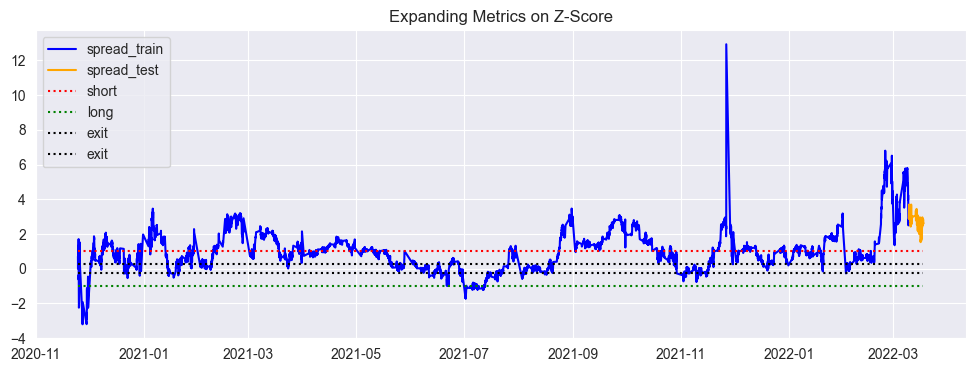

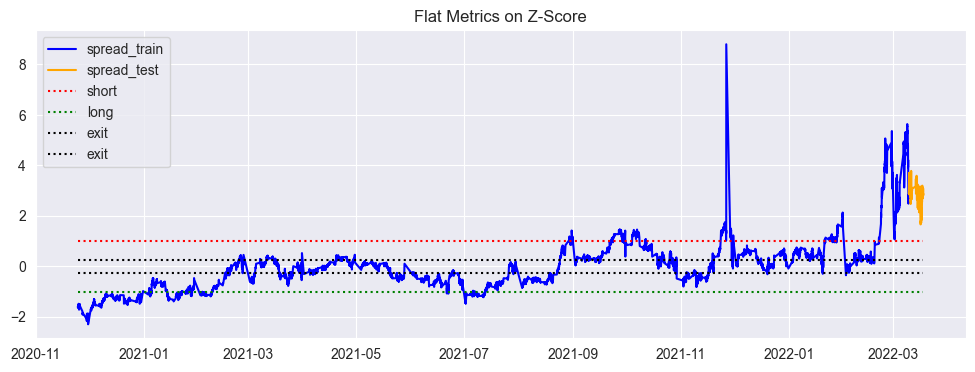

In [37]:
# Entry/Exit Signals - Z-score
z_entry = 1.0
z_exit = 0.25


# Use train (mean, std) for test
mean_train = df_train["spread"].mean()
std_train = df_train["spread"].std()
df_train["zscore_flat"] = (df_train["spread"] - mean_train) / std_train
df_test["zscore_flat"] = (df_test["spread"] - mean_train) / std_train

# Temporary join to roll the expanding metrics
df_train_test2 = pd.concat([df_train, df_test])
df_train_test2["zscore_expanding"] = (df_train_test2["spread"] - df_train_test2["spread"].expanding().mean()) / df_train_test2["spread"].expanding().std()

df_train = df_train_test2.iloc[0:len(df_train)]
df_test = df_train_test2.iloc[len(df_train):]

xmin=df_train.index[0]
xmax=df_test.index[-1]

# Plot expanding
plt.figure(figsize=(12, 4))
plt.plot(df_train.index, df_train["zscore_expanding"], color="blue", label="spread_train")
plt.plot(df_test.index, df_test["zscore_expanding"], color="orange", label="spread_test")
# plt.plot(df_train.index, df_train["zscore_flat"], color="darkblue", label="spread_train_flat")
# plt.plot(df_test.index, df_test["zscore_flat"], color="darkorange", label="spread_test_flat")
plt.hlines(z_entry, label="short", colors="red", linestyle="dotted", xmin=xmin, xmax=xmax)
plt.hlines(-z_entry, label="long", colors="green", linestyle="dotted", xmin=xmin, xmax=xmax)
plt.hlines(z_exit, label="exit", colors="blue", linestyle="dotted", xmin=xmin, xmax=xmax)
plt.hlines(-z_exit, label="exit", colors="blue", linestyle="dotted", xmin=xmin, xmax=xmax)
plt.legend()
plt.title("Expanding Metrics on Z-Score")
plt.show()

# Plot flat WITHOUT look-ahead
plt.figure(figsize=(12, 4))
plt.plot(df_train.index, df_train["zscore_flat"], color="blue", label="spread_train")
plt.plot(df_test.index, df_test["zscore_flat"], color="orange", label="spread_test")
plt.hlines(z_entry, label="short", colors="red", linestyle="dotted", xmin=xmin, xmax=xmax)
plt.hlines(-z_entry, label="long", colors="green", linestyle="dotted", xmin=xmin, xmax=xmax)
plt.hlines(z_exit, label="exit", colors="blue", linestyle="dotted", xmin=xmin, xmax=xmax)
plt.hlines(-z_exit, label="exit", colors="blue", linestyle="dotted", xmin=xmin, xmax=xmax)
plt.legend()
plt.title("Flat Metrics on Z-Score")
plt.show()

In [ ]:
## Save plots: name contains date of W/C.

In [40]:
## Do trades

# Generate entry/exit signals
threshold_col = "zscore_expanding"
df_test["long"] = 1.0 * (df_test[threshold_col] <= -z_entry)
df_test["short"] = 1.0 * (df_test[threshold_col] >= z_entry)
df_test["exit"] = 1.0 * (np.abs(df_test[threshold_col]) <= z_exit)

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_1303/4148362.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["long"] = 1.0 * (df_test[threshold_col] <= -z_entry)
/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_1303/4148362.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["short"] = 1.0 * (df_test[threshold_col] >= z_entry)
/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_1303/4148362.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [43]:
from algo.execution.positions import compute_positions, compute_returns


df_test = df_test.pipe(compute_positions)
df_test = df_test.pipe(compute_returns)

df_test[["returns_cml", "returns_cml_S1", "returns_cml_S2"]].plot()
plt.title("Test Set")
plt.show()

In [45]:
from algo.performance.sharpe import sharpe_ratio_log


sharpe_ratio = sharpe_ratio_log(df_test)
sharpe_ratio_annual = sharpe_ratio*np.sqrt(23*252)

print(f"Sharpe Ratio Test Annual = {sharpe_ratio_annual}")

Sharpe Ratio Annual = 0.9446739627882383


In [51]:
## After test window num_data points elapses, add to training set


## Test set is next test window


## Repeat: re-train, etc..